# Dependencies

In [1]:
import os
import cv2
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

### Auxiliary functions

In [2]:
def rle_to_mask(rle_string, height, width):
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img
    
def get_mask_area(df, index, column_name, shape=(1400, 2100)):
    rle = df.loc[index][column_name]
    try:
        math.isnan(rle)
        np_mask = np.zeros((shape[0], shape[1], 3))
    except:
        np_mask = rle_to_mask(rle, shape[0], shape[1])
        np_mask = np.clip(np_mask, 0, 1)
        
    return int(np.sum(np_mask))

# Load data

In [3]:
train_df = pd.read_csv('../input/understanding_cloud_organization/train.csv')

# Preprocecss data
train_df['image'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['label'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])

# Create one column for each mask
train_pivoted = pd.pivot_table(train_df, index=['image'], values=['EncodedPixels'], columns=['label'], aggfunc=np.min).reset_index()
train_pivoted.columns = ['image', 'Fish_mask', 'Flower_mask', 'Gravel_mask', 'Sugar_mask']

# Create meta information about the labels
train_df = train_df[~train_df['EncodedPixels'].isnull()]
classes = train_df['label'].unique()
train_df = train_df.groupby(['image'])['label'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['label'].map(lambda x: 1 if class_name in x else 0)

# Join data sets
train_df = train_df.merge(train_pivoted)
train_df['n_masks'] = train_df['label'].apply(lambda x: len(x))

# Calculate masks area
train_df['Fish_area'] = 0
train_df['Flower_area'] = 0
train_df['Gravel_area'] = 0
train_df['Sugar_area'] = 0

for i, row in train_df.iterrows():
    train_df['Fish_area'].loc[i] = get_mask_area(train_df, i,'Fish_mask')
    train_df['Flower_area'].loc[i] = get_mask_area(train_df, i,'Flower_mask')
    train_df['Gravel_area'].loc[i] = get_mask_area(train_df, i,'Gravel_mask')
    train_df['Sugar_area'].loc[i] = get_mask_area(train_df, i,'Sugar_mask')
    
display(train_df.head())

,image,label,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,n_masks,Fish_area,Flower_area,Gravel_area,Sugar_area
0,0011165.jpg,"{Fish, Flower}",1,1,0,0,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,2,932312,1156107,0,0
1,002be4f.jpg,"{Fish, Sugar, Flower}",1,1,1,0,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,3,1684325,592697,0,313950
2,0031ae9.jpg,"{Fish, Sugar, Flower}",1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,3,1240822,1178858,0,306908
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN,2,0,655989,289939,0
4,003994e.jpg,"{Fish, Sugar, Gravel}",1,0,1,1,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,3,183231,0,410592,216627


# Hold-out train validation split (20%)

In [4]:
train, validation = train_test_split(train_df, test_size=0.2, stratify=train_df['label'].map(lambda x: list(x)), random_state=seed)

### Class distribution

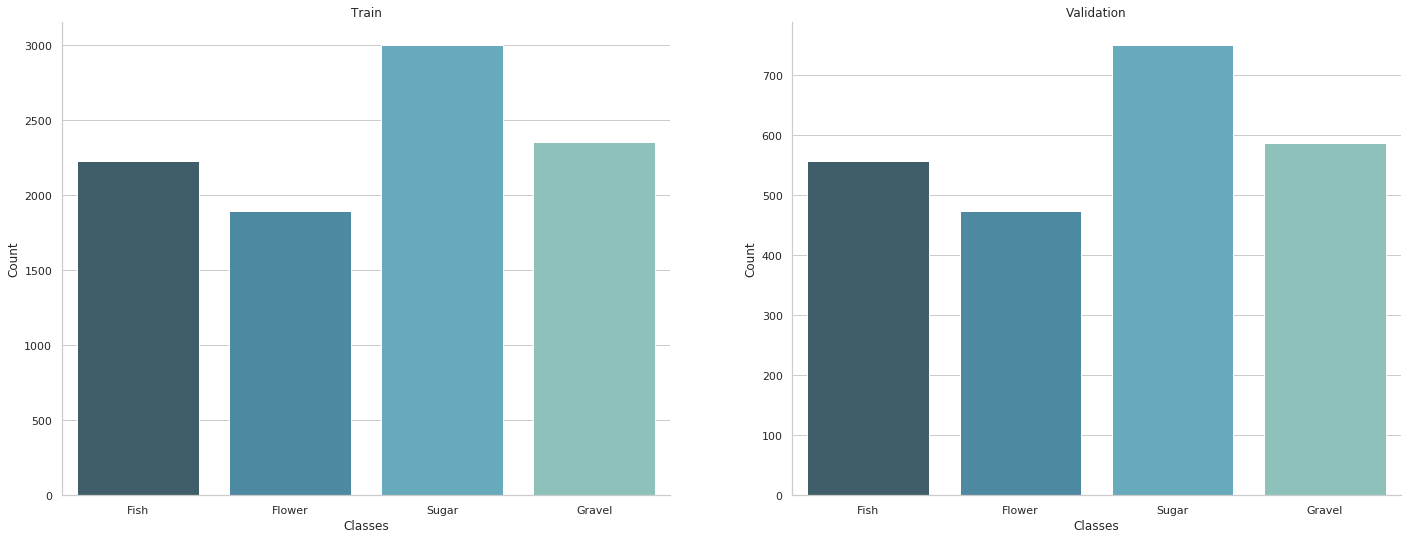

In [5]:
train_classes = train[['Fish', 'Flower', 'Sugar', 'Gravel']].agg(np.sum).reset_index()
validation_classes = validation[['Fish', 'Flower', 'Sugar', 'Gravel']].agg(np.sum).reset_index()
train_classes.columns = ['Classes', 'Count']
validation_classes.columns = ['Classes', 'Count']

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.barplot(x="Classes", y="Count", data=train_classes, palette="GnBu_d", ax=ax1).set_title('Train')
sns.barplot(x="Classes", y="Count", data=validation_classes, palette="GnBu_d", ax=ax2).set_title('Validation')
sns.despine()
plt.show()

### Mask count distribution

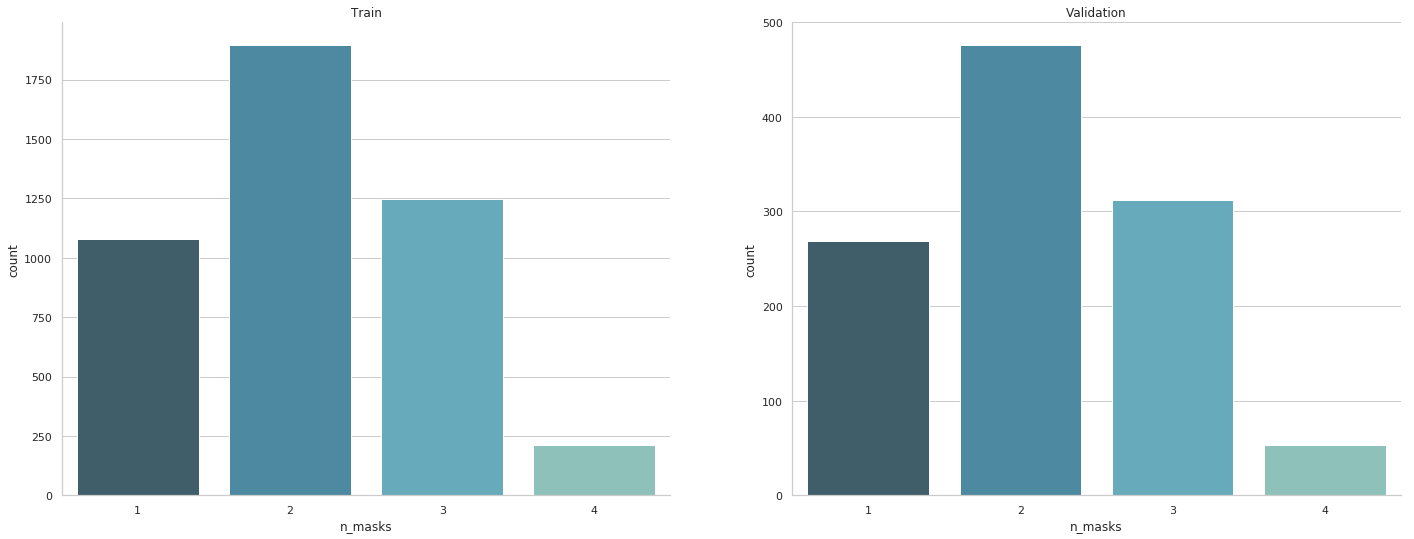

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.countplot(x="n_masks", data=train, palette="GnBu_d", ax=ax1).set_title('Train')
sns.countplot(x="n_masks", data=validation, palette="GnBu_d", ax=ax2).set_title('Validation')
sns.despine()
plt.show()

### Mask area distribution

In [7]:
display(train[['Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area']].describe().T)
display(validation[['Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area']].describe().T)

,count,mean,std,min,25%,50%,75%,max
Fish_area,4436.0,435072.750451,570026.350216,0.0,0.0,76696.0,769012.00,2824276.0
Flower_area,4436.0,409049.176736,605375.885010,0.0,0.0,0.0,722532.75,2831912.0
Gravel_area,4436.0,443424.637060,581093.673758,0.0,0.0,200911.5,737777.25,2838676.0
Sugar_area,4436.0,482877.314022,501265.520941,0.0,0.0,376552.0,777591.00,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1110.0,432122.069369,567939.012963,0.0,0.0,98563.5,754103.25,2852894.0
Flower_area,1110.0,398583.072973,597858.721021,0.0,0.0,0.0,693451.25,2884611.0
Gravel_area,1110.0,447746.516216,595367.733448,0.0,0.0,216144.0,726693.25,2850605.0
Sugar_area,1110.0,486211.614414,517251.133317,0.0,0.0,347648.0,803398.25,2709609.0


# Output hold-out set

In [8]:
train['set'] = 'train'
validation['set'] = 'validation'
train_complete = train.append(validation)[['image', 'Fish_mask', 'Flower_mask', 'Gravel_mask', 'Sugar_mask', 'set']]
train_complete.to_csv('hold-out.csv', index=False)
display(train_complete.head())

,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,set
4365,c9629d8.jpg,NaN,1082202 658 1083602 658 1085002 658 1086402 65...,1134924 476 1136324 476 1137724 476 1139124 47...,1674 417 3074 417 4474 417 5874 417 7274 417 8...,train
5056,e8e25ab.jpg,239 463 1639 463 3039 463 4439 463 5839 463 72...,1029006 350 1030406 350 1031806 350 1033206 35...,NaN,5606 574 7006 574 8406 574 9806 574 11206 574 ...,train
1089,31c1874.jpg,959762 410 961162 410 962562 410 963962 410 96...,751962 1228 753362 1228 754762 1228 756162 122...,NaN,NaN,train
3572,a396614.jpg,NaN,NaN,17941 239 19341 239 20741 239 22141 239 23541 ...,3030 665 4430 665 5830 665 7230 665 8574 1226 ...,train
1880,560dedf.jpg,6555 444 7955 444 8437 897 9355 444 9837 897 1...,NaN,NaN,1409 644 2809 644 4209 644 5609 644 7009 644 8...,train


# 5-Fold split

In [9]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['n_masks'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % fold_n)] = 0
    train_df[('fold_%s' % fold_n)].loc[train_idx] = 'train'
    train_df[('fold_%s' % fold_n)].loc[val_idx] = 'validation'
    
display(train_df.head())

Fold: 0, Train size: 4435, Validation size 1111
Fold: 1, Train size: 4436, Validation size 1110
Fold: 2, Train size: 4437, Validation size 1109
Fold: 3, Train size: 4438, Validation size 1108
Fold: 4, Train size: 4438, Validation size 1108


,image,label,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,n_masks,Fish_area,Flower_area,Gravel_area,Sugar_area,fold_0,fold_1,fold_2,fold_3,fold_4
0,0011165.jpg,"{Fish, Flower}",1,1,0,0,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,2,932312,1156107,0,0,train,train,validation,train,train
1,002be4f.jpg,"{Fish, Sugar, Flower}",1,1,1,0,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,3,1684325,592697,0,313950,train,train,validation,train,train
2,0031ae9.jpg,"{Fish, Sugar, Flower}",1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,3,1240822,1178858,0,306908,train,train,train,train,validation
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN,2,0,655989,289939,0,validation,train,train,train,train
4,003994e.jpg,"{Fish, Sugar, Gravel}",1,0,1,1,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,3,183231,0,410592,216627,train,train,validation,train,train


### Class distribution

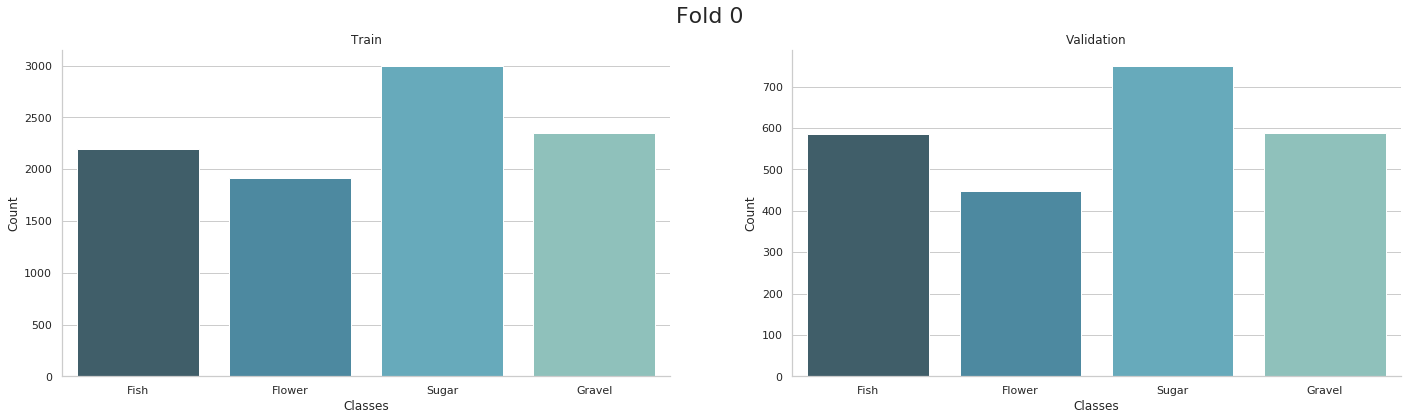

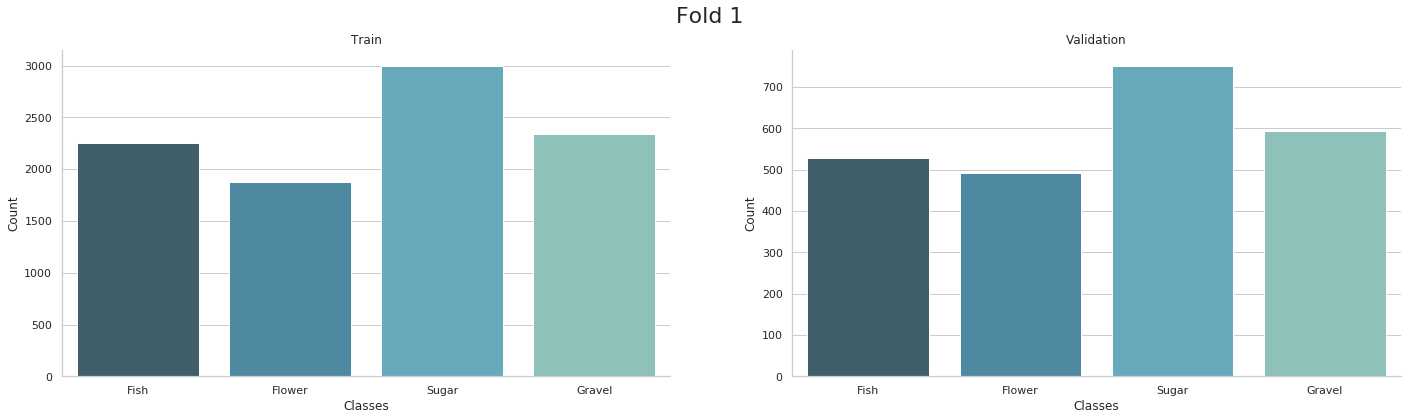

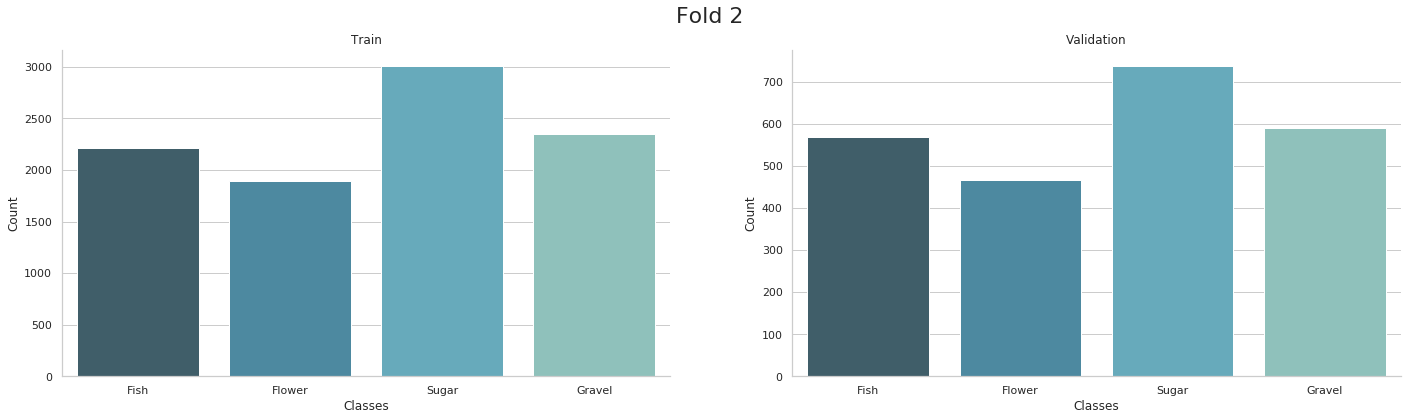

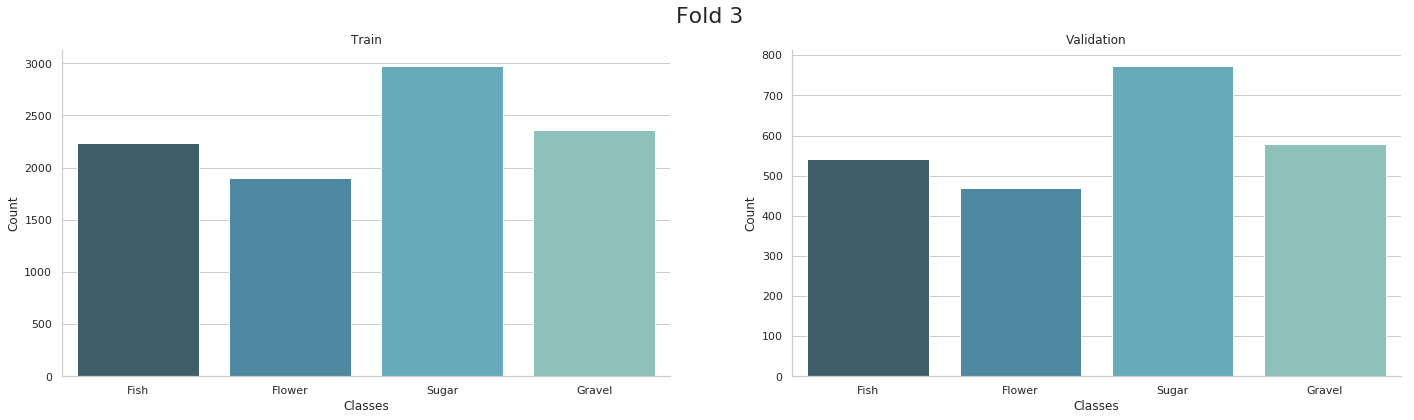

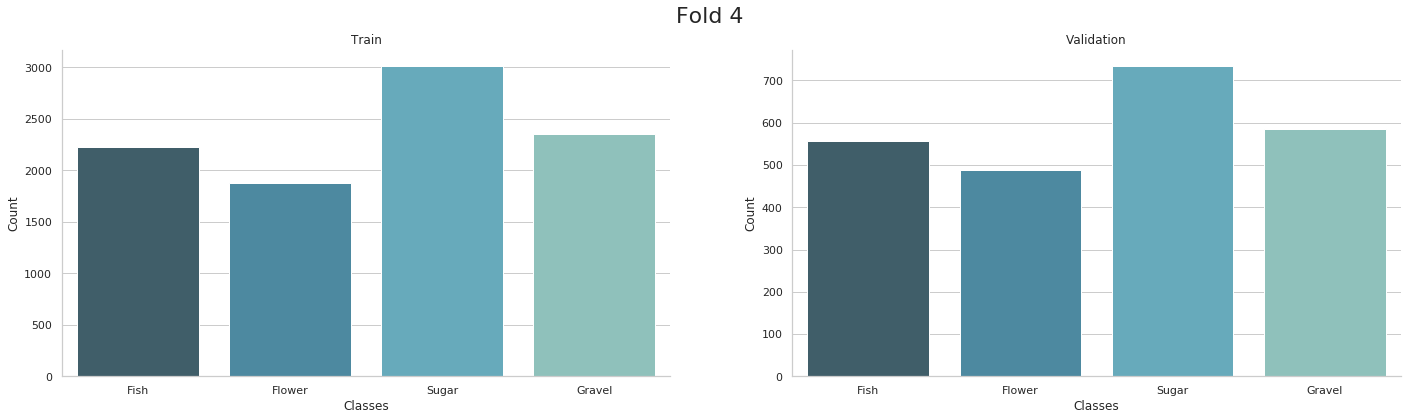

In [10]:
for fold_n in range(folds.n_splits):
    train_classes = train_df[train_df[('fold_%s' % fold_n)] == 'train'][['Fish', 'Flower', 'Sugar', 'Gravel']].agg(np.sum).reset_index()
    validation_classes = train_df[train_df[('fold_%s' % fold_n)] == 'validation'][['Fish', 'Flower', 'Sugar', 'Gravel']].agg(np.sum).reset_index()
    train_classes.columns = ['Classes', 'Count']
    validation_classes.columns = ['Classes', 'Count']

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)
    sns.barplot(x="Classes", y="Count", data=train_classes, palette="GnBu_d", ax=ax1).set_title('Train')
    sns.barplot(x="Classes", y="Count", data=validation_classes, palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

### Mask count distribution

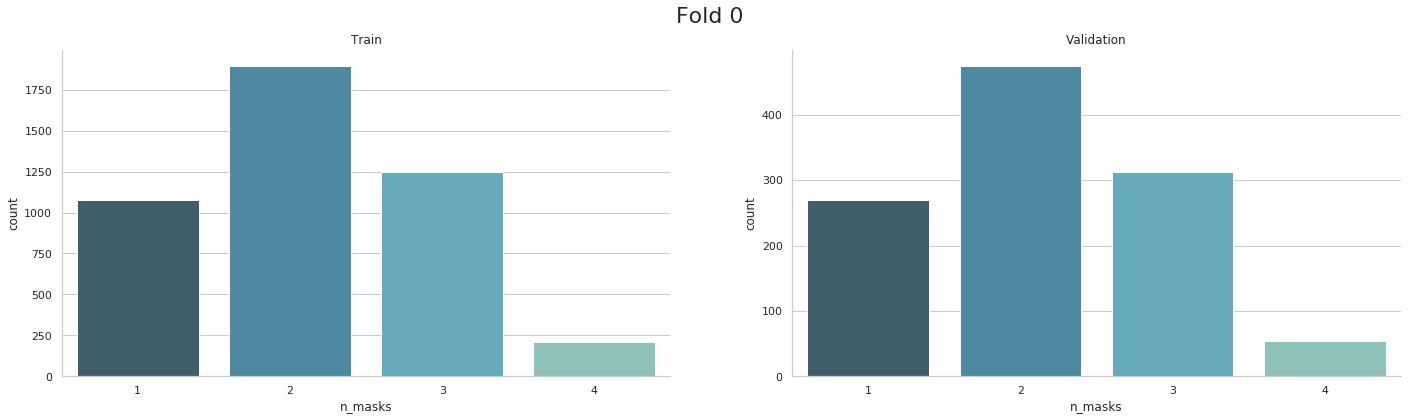

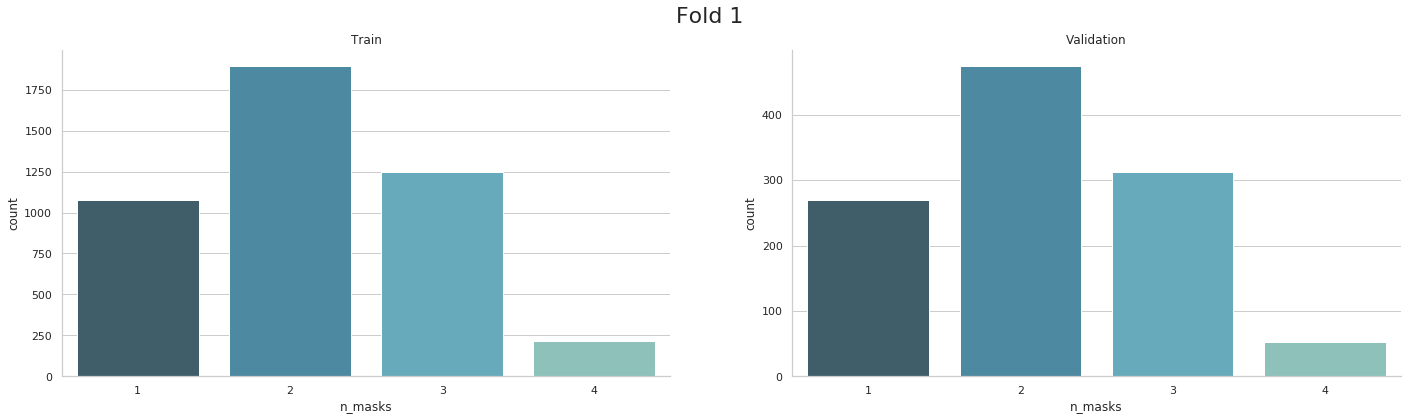

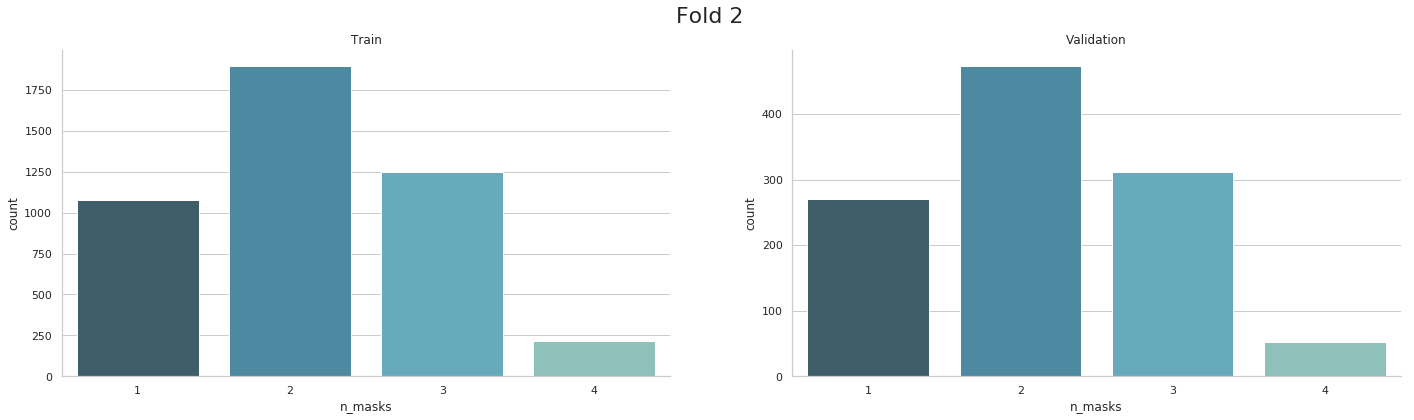

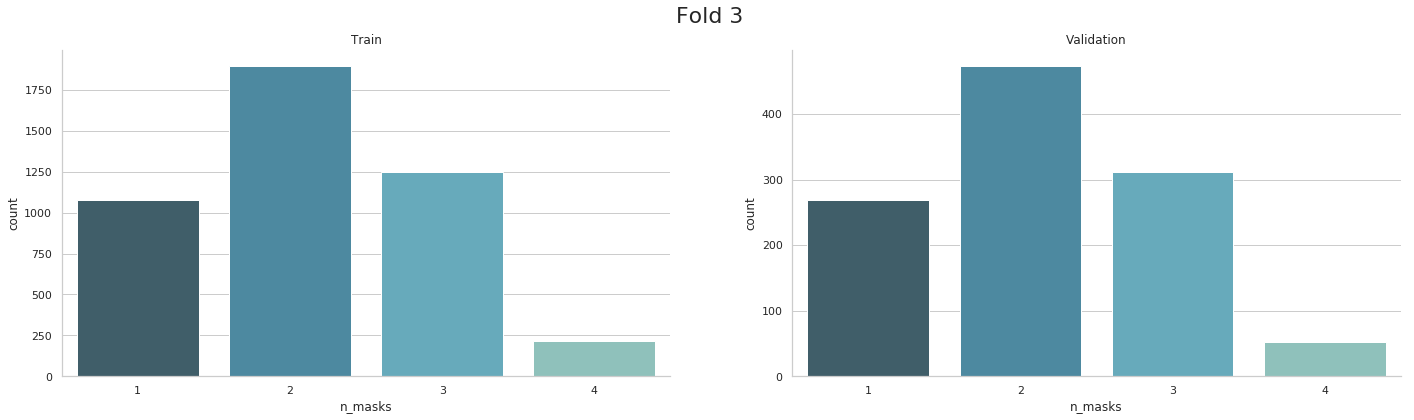

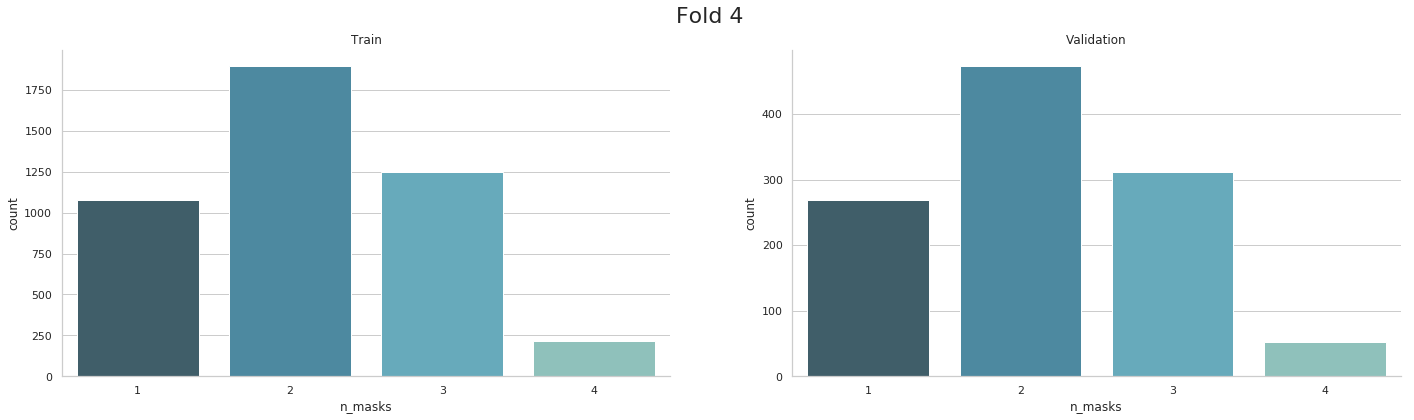

In [11]:
for fold_n in range(folds.n_splits):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="n_masks", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="n_masks", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

### Mask area distribution

In [12]:
for fold_n in range(folds.n_splits):
    print('Fold %s' % fold_n)    
    display(train_df[train_df[('fold_%s' % fold_n)] == 'train'][['Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area']].describe().T)
    display(train_df[train_df[('fold_%s' % fold_n)] == 'validation'][['Fish_area', 'Flower_area', 'Gravel_area', 'Sugar_area']].describe().T)

Fold 0


,count,mean,std,min,25%,50%,75%,max
Fish_area,4435.0,426977.938670,566159.297203,0.0,0.0,0.0,758820.5,2824276.0
Flower_area,4435.0,412271.011048,605484.892044,0.0,0.0,0.0,723829.5,2884611.0
Gravel_area,4435.0,448169.689741,586899.395317,0.0,0.0,204721.0,740155.0,2850605.0
Sugar_area,4435.0,482999.624126,503377.444378,0.0,0.0,373888.0,776542.0,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1111.0,464438.397840,582229.896910,0.0,0.0,225218.0,810485.0,2852894.0
Flower_area,1111.0,385731.255626,597025.789148,0.0,0.0,0.0,675157.0,2676664.0
Gravel_area,1111.0,428800.854185,571904.505752,0.0,0.0,196920.0,704232.0,2780960.0
Sugar_area,1111.0,485720.363636,508980.929979,0.0,0.0,354943.0,807229.0,2658342.0


Fold 1


,count,mean,std,min,25%,50%,75%,max
Fish_area,4436.0,436663.228359,566776.189617,0.0,0.0,134044.0,766756.00,2852894.0
Flower_area,4436.0,400619.727683,596975.093294,0.0,0.0,0.0,708806.75,2804128.0
Gravel_area,4436.0,444579.342426,585525.181660,0.0,0.0,202806.5,741185.75,2850605.0
Sugar_area,4436.0,485129.837917,507772.248697,0.0,0.0,367480.5,784476.50,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1110.0,425765.889189,580725.799510,0.0,0.0,0.0,754360.25,2824276.0
Flower_area,1110.0,432270.492793,630170.169738,0.0,0.0,0.0,745661.75,2884611.0
Gravel_area,1110.0,443131.855856,577755.271183,0.0,0.0,213220.0,710893.25,2737346.0
Sugar_area,1110.0,477209.636036,491173.288652,0.0,0.0,381411.5,776873.25,2627527.0


Fold 2


,count,mean,std,min,25%,50%,75%,max
Fish_area,4437.0,433927.781384,570759.502109,0.0,0.0,0.0,763856.0,2852894.0
Flower_area,4437.0,403875.941176,598976.088453,0.0,0.0,0.0,708905.0,2884611.0
Gravel_area,4437.0,443005.547667,581947.597100,0.0,0.0,202960.0,732326.0,2838676.0
Sugar_area,4437.0,488671.661258,507218.973095,0.0,0.0,372525.0,789177.0,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1109.0,436700.317403,564982.214923,0.0,0.0,144047.0,770470.0,2767797.0
Flower_area,1109.0,419271.242561,623043.437215,0.0,0.0,0.0,743948.0,2788978.0
Gravel_area,1109.0,449427.148783,592016.606764,0.0,0.0,205155.0,747103.0,2850605.0
Sugar_area,1109.0,463032.007214,492958.816178,0.0,0.0,351162.0,751902.0,2709609.0


Fold 3


,count,mean,std,min,25%,50%,75%,max
Fish_area,4438.0,439798.555430,572641.720473,0.0,0.0,111234.0,780423.00,2852894.0
Flower_area,4438.0,413019.168770,613019.118730,0.0,0.0,0.0,728906.75,2884611.0
Gravel_area,4438.0,439693.446598,577620.319822,0.0,0.0,203661.0,721940.25,2850605.0
Sugar_area,4438.0,476354.696710,498525.308796,0.0,0.0,362984.0,776999.50,2709609.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1108.0,413187.932310,556787.168873,0.0,0.0,0.0,711691.25,2744133.0
Flower_area,1108.0,382662.714801,565192.766079,0.0,0.0,0.0,680818.00,2515056.0
Gravel_area,1108.0,462699.284296,608453.253728,0.0,0.0,202694.0,751003.00,2838676.0
Sugar_area,1108.0,512343.423285,526811.664013,0.0,0.0,393132.5,795868.25,2714106.0


Fold 4


,count,mean,std,min,25%,50%,75%,max
Fish_area,4438.0,435039.224425,571412.077652,0.0,0.0,72976.0,766977.50,2852894.0
Flower_area,4438.0,404986.428121,604579.273933,0.0,0.0,0.0,709340.50,2884611.0
Gravel_area,4438.0,446002.619198,587615.895031,0.0,0.0,202910.5,731138.50,2850605.0
Sugar_area,4438.0,484568.956512,505327.993420,0.0,0.0,369865.5,783388.25,2714106.0


,count,mean,std,min,25%,50%,75%,max
Fish_area,1108.0,432251.028881,562326.806740,0.0,0.0,95259.0,765097.50,2647863.0
Flower_area,1108.0,414837.175993,601075.812348,0.0,0.0,0.0,750798.75,2804128.0
Gravel_area,1108.0,437428.428700,569119.384553,0.0,0.0,208542.5,748202.00,2603518.0
Sugar_area,1108.0,479441.902527,501174.354254,0.0,0.0,367186.0,775499.50,2453610.0


# Output 5-fold set

In [13]:
train_complete = train_df.drop(['label', 'Fish', 'Flower', 'Gravel', 'Sugar', 'n_masks'], axis=1)
train_complete.to_csv('5-fold.csv', index=False)
display(train_complete.head())

,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish_area,Flower_area,Gravel_area,Sugar_area,fold_0,fold_1,fold_2,fold_3,fold_4
0,0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,932312,1156107,0,0,train,train,validation,train,train
1,002be4f.jpg,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,1684325,592697,0,313950,train,train,validation,train,train
2,0031ae9.jpg,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,1240822,1178858,0,306908,train,train,train,train,validation
3,0035239.jpg,NaN,100812 462 102212 462 103612 462 105012 462 10...,65400 380 66800 380 68200 380 69600 380 71000 ...,NaN,0,655989,289939,0,validation,train,train,train,train
4,003994e.jpg,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,183231,0,410592,216627,train,train,validation,train,train
